<a href="https://colab.research.google.com/github/Pashtetickus/TEMPreview/blob/master/simpsons_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# The begin

Hi!

Ссылка на обученные веса (в конце код для их загрузки в модель):
https://drive.google.com/open?id=1-ep7OD0lYP_3NZGAbMbw2TUyY5opzzzs

### Установка зависимостей

In [ ]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)


In [ ]:
import torch

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
# Путь к датасету на моем гугл диске
!unzip -q /content/gdrive/My\ Drive/Kaggle/simpsons4/data/journey-springfield.zip


In [ ]:
!nvidia-smi
torch.cuda.is_available()

Fri May  8 22:13:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

SEED = 42
import random

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [ ]:
from PIL import Image

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])

        # аугментация
        transform2 = transforms.Compose([
            transforms.ColorJitter(brightness=(0.5,1.5), contrast=(0.7,1.3), saturation=(0.7,1.3)),
            transforms.RandomAffine((-25,25), (0,0.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        
        

        if self.mode == 'train':
            x= Image.fromarray(x, 'RGB')
            x = transform2(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        elif self.mode == 'val':
            x= Image.fromarray(x, 'RGB')
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
          x = transform(x)
          return x
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))

test_files = sorted(list(TEST_DIR.rglob('*.jpg')))



In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.01, \
                                          stratify=train_val_labels)
print(len(val_files))
print(len(train_files))

210
20723


In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

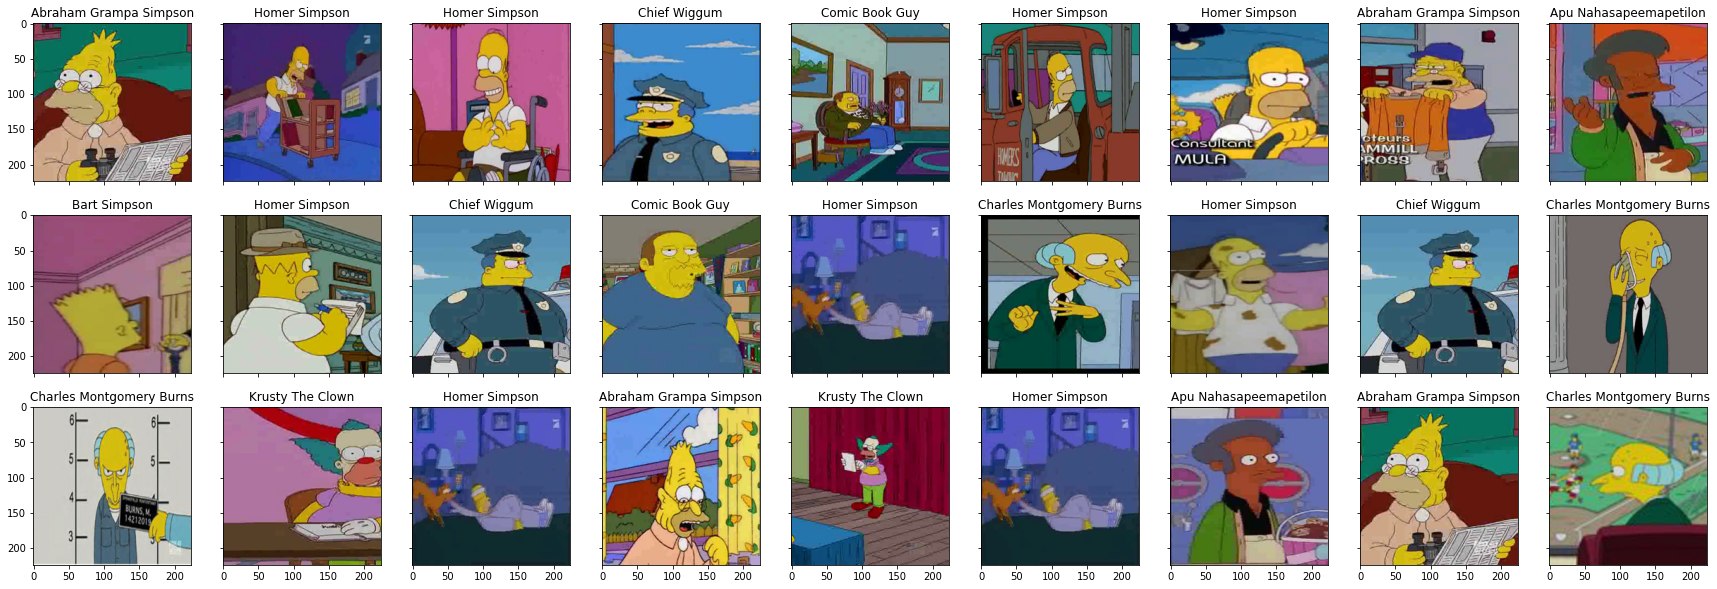

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=9,figsize=(30, 10), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,100))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    

In [ ]:
# все параметры модели тренируются
def set_parameter_requires_grad(model):
        for param in model.parameters():
            param.requires_grad = True

In [ ]:
# ResNet pretrained
class ResNet(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()

        self.model_ft = models.wide_resnet50_2(pretrained=True)
        set_parameter_requires_grad(self.model_ft)
        num_ftrs = self.model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(num_ftrs, n_classes)

    def forward(self, x):        

        logits = self.model_ft(x)
        return logits


In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size, l_r):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = l_r)
        criterion = nn.CrossEntropyLoss()
        # для уменьшения lr каждую эпоху в два раза
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()
            # для сохранения чекпоинтов на всякий случай
            torch.save(model.state_dict(), "/content/drive/My Drive/Kaggle/simpsons4/resnet/resnet_" + str(epoch) + ".pth")
 
            
    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))

model = ResNet(n_classes).to(DEVICE)

print("we will classify :{}".format(n_classes))
print(model)

we will classify :42
ResNet(
  (model_ft): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsamp

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
# model.load_state_dict(torch.load("Путь к весам"))

history = train(train_dataset, val_dataset, model=model, epochs=10, batch_size=32, l_r = 0.0001)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 0.5836861155132975


epoch:  10%|█         | 1/10 [07:37<1:08:35, 457.23s/it]


Epoch 001 train_loss: 0.5837     val_loss 10.1900 train_acc 0.8684 val_acc 0.0476
loss 0.21335941384351548


epoch:  20%|██        | 2/10 [15:12<1:00:52, 456.57s/it]


Epoch 002 train_loss: 0.2134     val_loss 14.8304 train_acc 0.9453 val_acc 0.0476
loss 0.07218526501279282


epoch:  30%|███       | 3/10 [22:46<53:12, 456.00s/it]


Epoch 003 train_loss: 0.0722     val_loss 16.5190 train_acc 0.9831 val_acc 0.0524
loss 0.0370786920485932


epoch:  40%|████      | 4/10 [30:22<45:34, 455.78s/it]


Epoch 004 train_loss: 0.0371     val_loss 15.2105 train_acc 0.9916 val_acc 0.0476
loss 0.02345613613368772


epoch:  50%|█████     | 5/10 [37:57<37:58, 455.74s/it]


Epoch 005 train_loss: 0.0235     val_loss 17.0094 train_acc 0.9945 val_acc 0.0476
loss 0.017871658153045394


epoch:  60%|██████    | 6/10 [45:32<30:22, 455.51s/it]


Epoch 006 train_loss: 0.0179     val_loss 17.2677 train_acc 0.9958 val_acc 0.0476
loss 0.013075600557220091


epoch:  70%|███████   | 7/10 [53:07<22:45, 455.18s/it]


Epoch 007 train_loss: 0.0131     val_loss 17.6021 train_acc 0.9970 val_acc 0.0476
loss 0.011248258575588553


epoch:  80%|████████  | 8/10 [1:00:42<15:10, 455.17s/it]


Epoch 008 train_loss: 0.0112     val_loss 18.1425 train_acc 0.9974 val_acc 0.0476
loss 0.011273715346840282


epoch:  90%|█████████ | 9/10 [1:08:16<07:34, 454.92s/it]


Epoch 009 train_loss: 0.0113     val_loss 18.2978 train_acc 0.9972 val_acc 0.0476
loss 0.010643470864301978


epoch: 100%|██████████| 10/10 [1:15:51<00:00, 454.99s/it]


Epoch 010 train_loss: 0.0106     val_loss 18.4444 train_acc 0.9978 val_acc 0.0476


epoch: 100%|██████████| 10/10 [1:15:52<00:00, 455.29s/it]


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

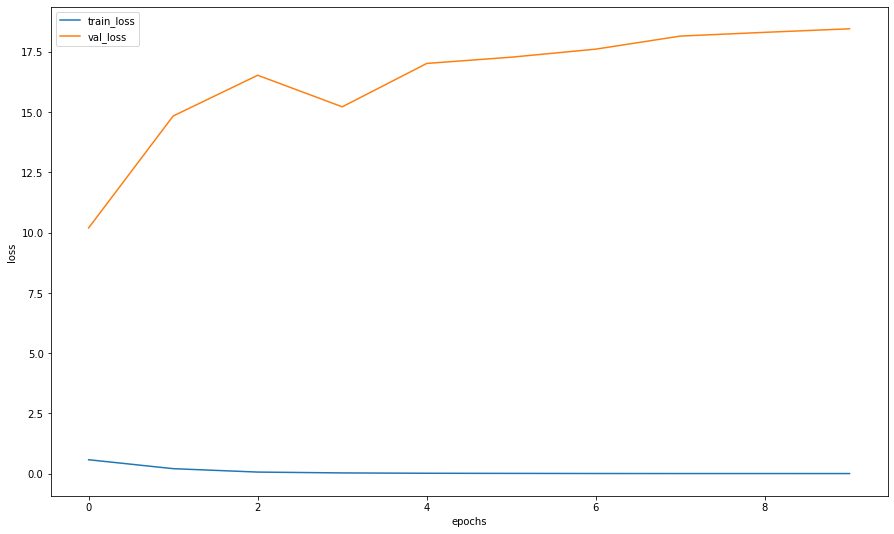

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Submit на Kaggle

Клетку ниже выполнить, если нужно проверить модель по готовым весам

In [ ]:
# n_classes = len(np.unique(train_labels))

# model = ResNet(n_classes).to(DEVICE)
# model.load_state_dict(torch.load('/content/resnet_9.pth')) # Ваш путь к скачанным весам
# model.eval()

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))

test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('Kaggle_sub_resnet50w.csv', index=False)